# Sign Language recognition on the Home made dataset

The goal of this notebook is to naturally extend the work done with the Sign MNIST dataset. We'll simply us the same network but will more layers and a different inputs (see our **New data - Data preparation**).

In [ ]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set a big font size
plt.rcParams.update({'font.size': 20})

In [ ]:
# Save folders
save_path = '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/FINAUX/saves/'
training = False

## Download the data

Let's load the dataset generated by the previous notebook.

In [ ]:
# Download the data
!unzip '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/new_data_filtered_splitted_v2.zip' 

Archive:  /content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/new_data_filtered_splitted_v2.zip
   creating: data_new/
   creating: data_new/train/
   creating: data_new/train/L/
  inflating: data_new/train/L/Maryline_L_204.jpg  
  inflating: data_new/train/L/AAG_L_185.jpg  
  inflating: data_new/train/L/Chong_L_116.jpg  
  inflating: data_new/train/L/Célian Latex _L_100.jpg  
  inflating: data_new/train/L/Olivier_L_64.jpg  
  inflating: data_new/train/L/Maryline_L_108.jpg  
  inflating: data_new/train/L/Maryline_L_42.jpg  
  inflating: data_new/train/L/Célian_L_184.jpg  
  inflating: data_new/train/L/Charles_L_88.jpg  
  inflating: data_new/train/L/Maryline_L_216.jpg  
  inflating: data_new/train/L/AAG_L_190.jpg  
  inflating: data_new/train/L/Maryline_L_210.jpg  
  inflating: data_new/train/L/Guillaume_L_80.jpg  
  inflating: data_new/train/L/Charles_L_76.jpg  
  inflating: data_new/train/L/Ines_L_52.jpg  
  inflating: data_new/train/L/AAG_L_130.jpg  
  inflating: data_new/tra

Now we build the training and validation generator as we did in the previous notebooks : 


*   Some data augmentation in the training data
*   Rescaling

One thing which has changed compared to previously is the size of the inputs (256,256).



In [ ]:
# Load the generators

## Build the generators

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rescale=1/255,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

## Load the data

train_generator = train_datagen.flow_from_directory(
    'data_new/train/',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'data_new/test/',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 3484 images belonging to 24 classes.
Found 947 images belonging to 24 classes.


In [ ]:
# Build and save the reverse dictionnary for outputs
class_indices_rev = { v : k for k,v in train_generator.class_indices.items() }
with open(save_path + 'class_indices_rev_new_data.pkl', 'wb') as f:
  pickle.dump(class_indices_rev, f)

In [ ]:
# Visualize a few images
plt.figure(figsize=(30,30), facecolor='white')
X_first_batch, y_first_batch = train_generator[0]
batch_size = X_first_batch.shape[0]
to_display = 32
to_display_sqrt = int(np.sqrt(to_display)) + 1
reverse_class_idx = { v : k for k,v in train_generator.class_indices.items() }
for i in range(to_display):
  plt.subplot(to_display_sqrt, to_display_sqrt, i+1)
  # Select an image
  im = X_first_batch[i,:,:,0] * 255
  plt.imshow(im, cmap='gray')
  plt.axis('off')
  plt.title(reverse_class_idx[np.argmax(y_first_batch[i])])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Build and train the model

We build a convolutionnal neural network with the following layers:

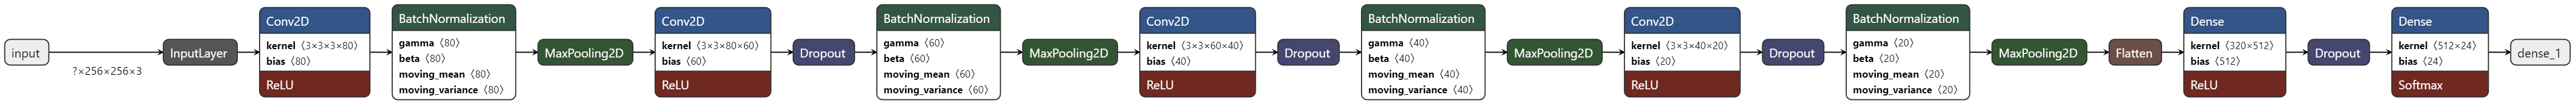

In [ ]:
# Build the model

## Callbacks
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

## Model
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(80, 3, strides=1, padding='same', activation='relu', input_shape=X_first_batch[0].shape),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2 , strides=2 , padding='same'),
	tf.keras.layers.Conv2D(60, 3, strides=2 , padding='same' , activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2 , strides=2 , padding='same'),
	tf.keras.layers.Conv2D(40, 3, strides=1 , padding='same' , activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2 , strides=2 , padding='same'),
	tf.keras.layers.Conv2D(20, 3, strides=2 , padding='same' , activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2 , strides=2 , padding='same'),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(512 , activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Dense(y_first_batch[0].shape[0], activation='softmax')
])
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 80)      2240      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 80)     320       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 80)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 60)        43260     
                                                                 
 dropout (Dropout)           (None, 64, 64, 60)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 60)       2

In [ ]:
# Build the model
if training:
  # Train the model
  chk_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path + 'model_new_data.h5', save_weights_only=False,
                                                    monitor='val_accuracy', mode='max', save_best_only=True)
  history = model.fit(train_generator, validation_data=test_generator, epochs=30, callbacks=[lr_callback, chk_callback])
  # Save the history
  with open(save_path + 'model_new_data_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
  history = history.history
else:
  # Load the model from saves
  model = tf.keras.models.load_model(save_path + 'model_new_data.h5')
  with open(save_path + 'model_new_data.pkl', 'rb') as f:
    history = pickle.load(f)

Epoch 1/30
55/55 [==============================] - 64s 1s/step - loss: 0.5498 - accuracy: 0.8321 - val_loss: 4.6810 - val_accuracy: 0.0106 - lr: 3.1250e-05
Epoch 2/30
55/55 [==============================] - 63s 1s/step - loss: 0.5473 - accuracy: 0.8315 - val_loss: 4.7271 - val_accuracy: 0.0106 - lr: 3.1250e-05
Epoch 3/30
55/55 [==============================] - 63s 1s/step - loss: 0.5420 - accuracy: 0.8269 - val_loss: 4.7555 - val_accuracy: 0.0106 - lr: 3.1250e-05
Epoch 4/30
55/55 [==============================] - 64s 1s/step - loss: 0.5324 - accuracy: 0.8350 - val_loss: 4.8309 - val_accuracy: 0.0116 - lr: 3.1250e-05
Epoch 5/30
55/55 [==============================] - 64s 1s/step - loss: 0.5543 - accuracy: 0.8229 - val_loss: 4.7621 - val_accuracy: 0.0106 - lr: 3.1250e-05
Epoch 6/30
55/55 [==============================] - 66s 1s/step - loss: 0.5477 - accuracy: 0.8263 - val_loss: 4.7104 - val_accuracy: 0.0106 - lr: 3.1250e-05
Epoch 7/30
55/55 [==============================] - 67s 1s

Let's visualize the learning curves :

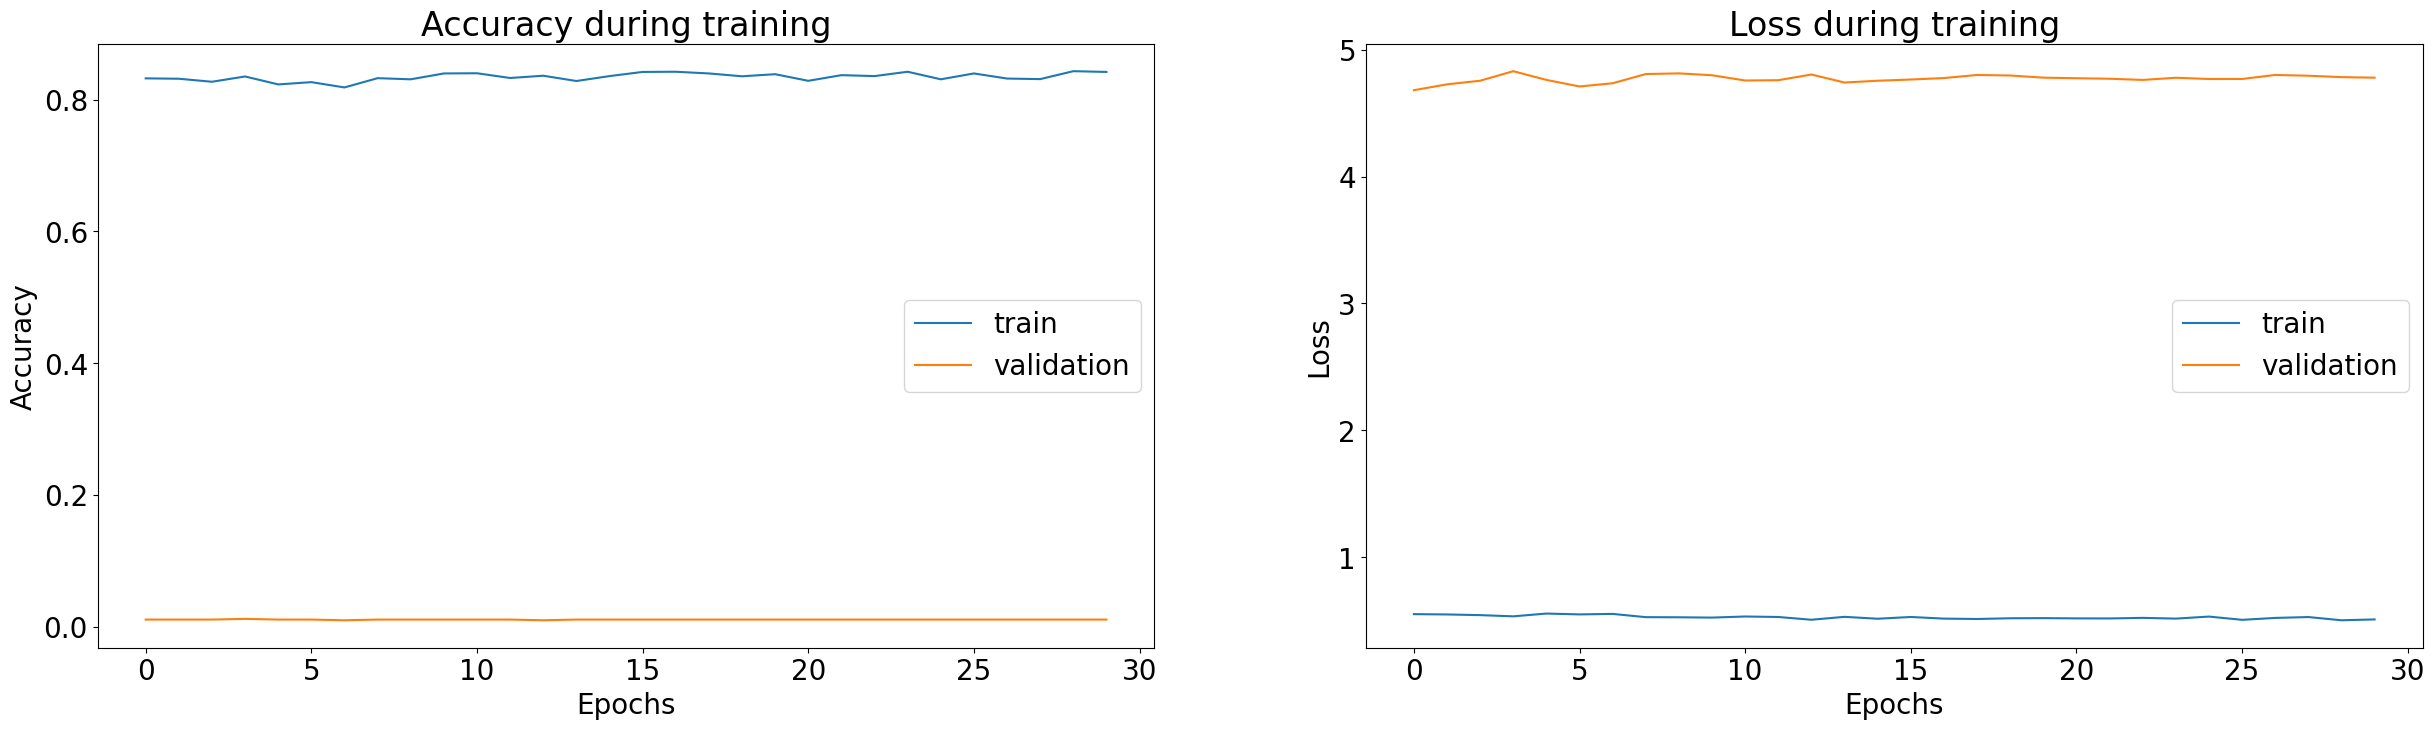

In [ ]:
# Plot the learning curve
plt.figure(figsize=(30,8), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during training')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

We can see that the network is very bad and doesn't learn anything on this new dataset...

### Results

In [ ]:
# Evaluate the model on the test dataset
result = model.evaluate(test_generator)

15/15 [==============================] - 5s 310ms/step - loss: 4.7796 - accuracy: 0.0106


## Understanding the prediction

### Confusion matrix

In [ ]:
# Make a prediction
from sklearn.metrics import accuracy_score

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=-1)
y_true = test_generator.classes
accuracy_score(y_true, y_pred)

0.010559662090813094

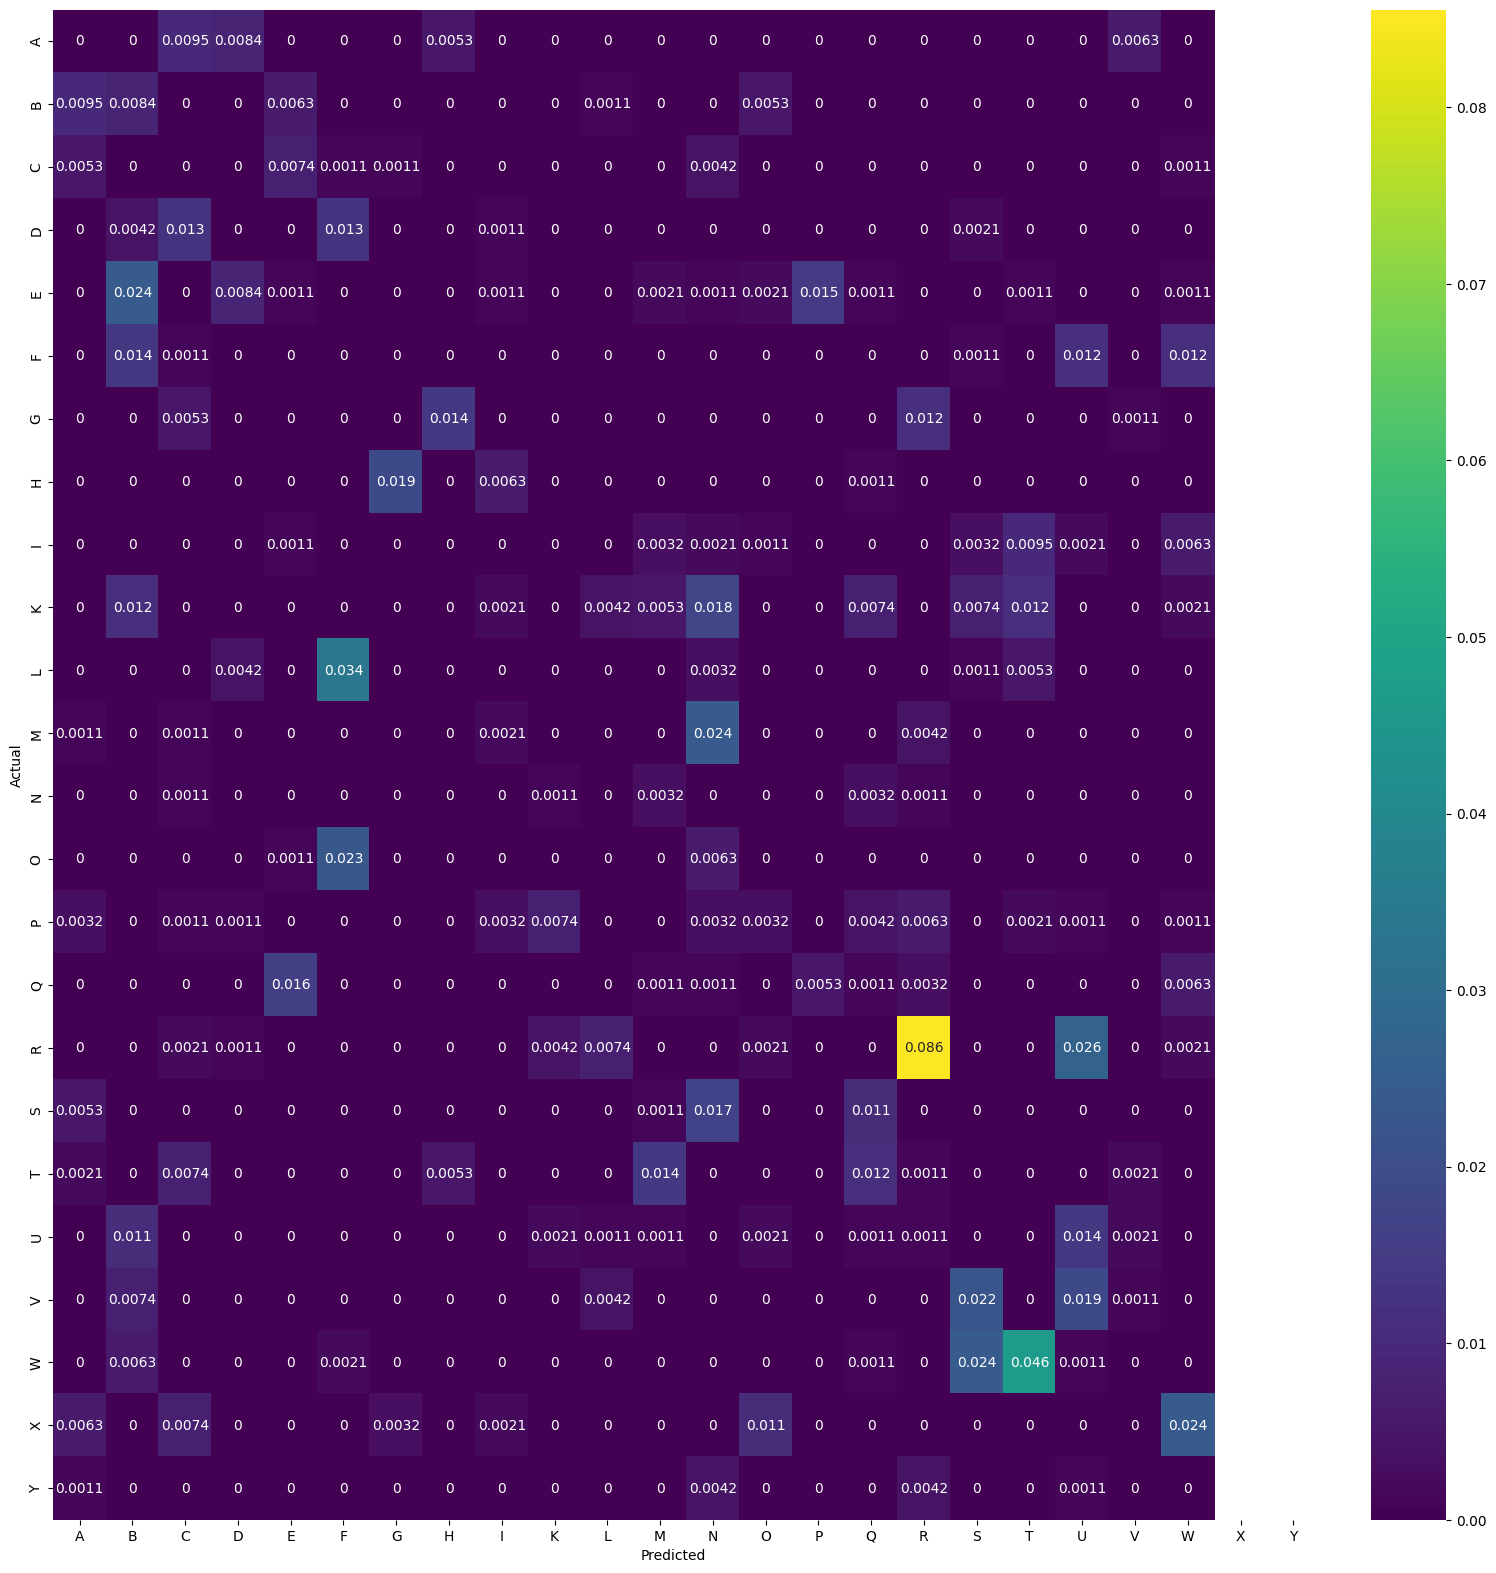

In [ ]:
# Make the confusion matrix
import pandas as pd
import seaborn as sns

## Build a dataframe
data = {
  'Actual labels': y_true,
  'Predicted labels': y_pred
}
axis_labels = reverse_class_idx.values()
df = pd.DataFrame(data, columns=['Actual labels','Predicted labels'])

## Compute the confusion matrix
confusion_matrix = pd.crosstab(df['Actual labels'], df['Predicted labels'], rownames=['Actual'], colnames=['Predicted'], normalize='all')

## Plot the heapmap
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, cmap='viridis')
plt.show()
plt.rcParams.update({'font.size': 20})

In [ ]:
len(set(df['Actual labels']))

24

In [ ]:
len(set(df['Predicted labels']))

22

Very surprisingly, the model was not able to learn anything and even didn't predict at all letters 'X' and 'Y'

### GradCam heatmaps

Let's visualize the heatmaps:

In [ ]:
# Download vizgradcam
!git clone https://github.com/gkeechin/vizgradcam
!cp vizgradcam/gradcam.py .

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


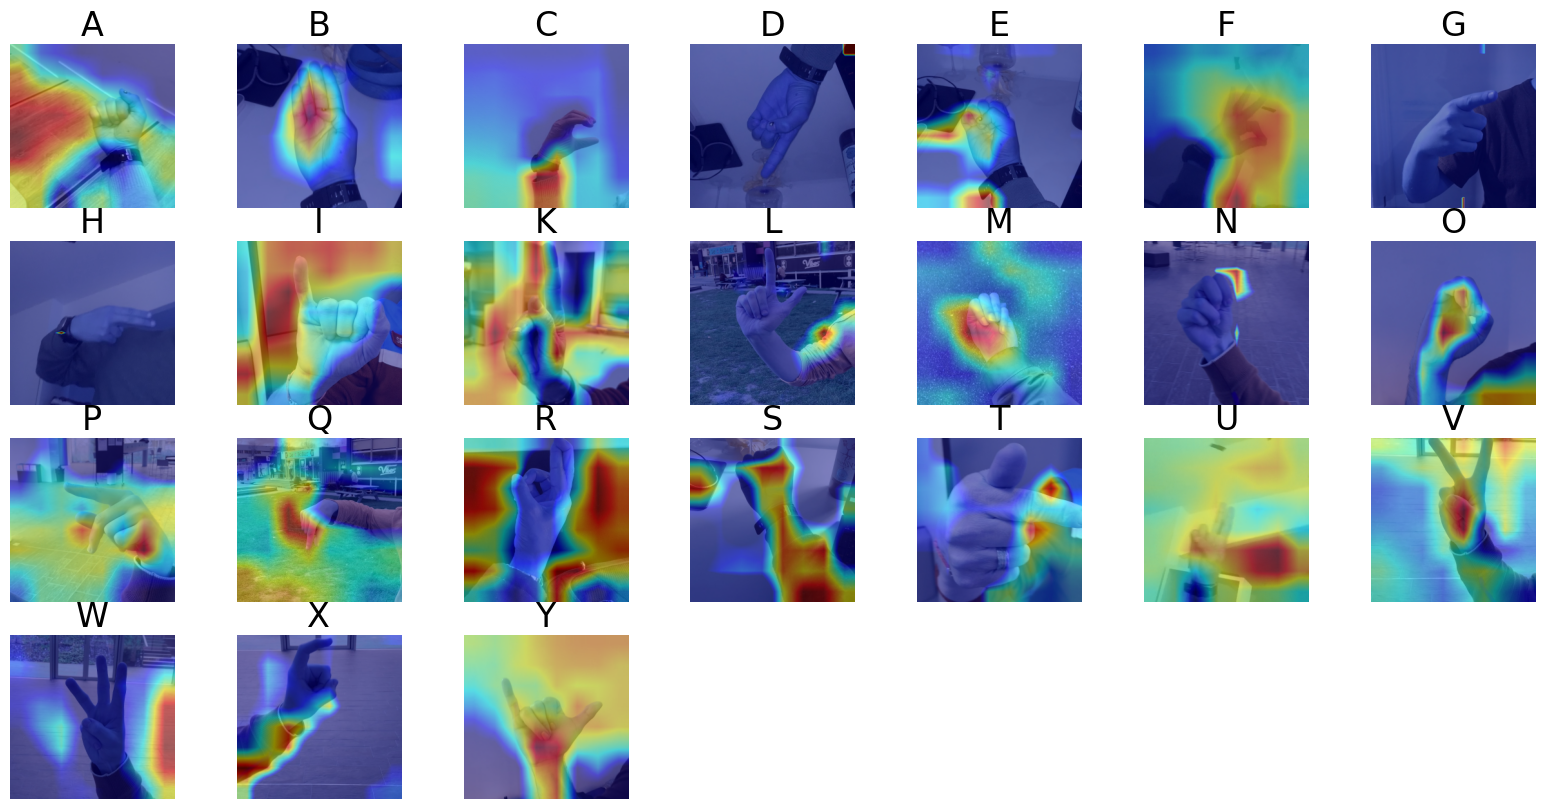

In [ ]:
# Visualize a few images

from gradcam import VizGradCAM
import cv2

plt.figure(figsize=(20,10))
for i, label in reverse_class_idx.items():
  plt.subplot(4, 7, i+1)
  # Select an image
  idx = np.argmax(test_generator.classes == i)
  filename = '/content/data_new/test/' + test_generator.filenames[idx]
  im = cv2.imread(filename)
  im = cv2.resize(im, (256,256))
  im = np.array(im) / 255
  # Calculer Grad-CAM
  interpolant = 0.5
  cvt_heatmap = VizGradCAM(model, im, plot_results=False, interpolant=interpolant)
  plt.imshow(np.uint8(im * 255 * interpolant + cvt_heatmap * (1 - interpolant)))
  plt.axis('off')
  plt.title(label)
plt.show()

It seems that some times the network "looks" at the right place (the hand) but is still not able to learn...